In [2]:
import torch
import torch.nn as nn

In [4]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [5]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [6]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T


        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon
    

    # The next two functions are added for the classifier guided sampling

    def get_gradients_classifier(self,classifier, x_t, t, y):
        """
        Get gradients of the classifier model with respect to the input x_t
        for a specific class y
        """
        with torch.enable_grad():
            x_t = x_t.clone().detach().requires_grad_(True)  # shape: nsamples, 28x28
            #shape of t: nsamples, 1

            #the shape of output is the problem, should be nsamples, 10
            t1= t[0]
            output = classifier(x_t, t1)  # shape: nsamples, nsamples, 10

            scalar_value =torch.mean(output[:, y])# This scalar value represents the total contribution of class y across all instances in the batch.

            grads = torch.autograd.grad(scalar_value, x_t)[0] #shape: same as x_t

        return grads


    def reverse_diffusion_guided(self,classifier, xt, t, y, weight, epsilon):
        grads = self.get_gradients_classifier(classifier, xt, t, y) # get gradients, but dimension 28x28 
        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        mean_guided = mean + weight * std**2 * grads

        return mean_guided + std*epsilon
    
    @torch.no_grad()
    def sample(self, shape, weight = 0 ,y=None, classifier = None):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT

        if weight == 0:
            for t in range(self.T, 0, -1):
                noise = torch.randn_like(xT) if t > 1 else 0
                t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
                xt = self.reverse_diffusion(xt, t, noise)


        # This part is added for the classifier guided sampling
        # If weight is not 0, then we are doing the guided sampling are calling the reverse_diffusion_guided function
        else:
            for t in range(self.T, 0, -1):
                noise = torch.randn_like(xT) if t > 1 else 0
                t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
                
                #with torch.enable_grad():
                xt = self.reverse_diffusion_guided(classifier, xt, t, y, weight, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)



In [ ]:

# Parameters
T = 1000
learning_rate = 1e-3
epochs = 50
batch_size = 64


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).to(device)
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

# Training a Classifier

Training a classifier $f_\theta(y|x_t,t)$ on noisy data $x_t, t$ from the forward diffusion process.

In [9]:
class Classifier(nn.Module):
    def __init__(self, embed_dim=128):
        super(Classifier, self).__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (28x28 pixels flattened)
        self.fc2 = nn.Linear(128, 64)    # Hidden layer
        self.fc3 = nn.Linear(64, 10)     # Output layer (10 classes)
        self.relu = nn.ReLU()
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        t_embedding = self.act(self.embed(t))
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x)+ t_embedding)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x



def get_noisy_datasets(diff_model, batch_size=64, device=device):

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
        transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
        transforms.Lambda(lambda x: x.flatten())
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_dataset.data = train_dataset.data.to(device)
    train_dataset.targets = train_dataset.targets.to(device)
    test_dataset.data = test_dataset.data.to(device)
    test_dataset.targets = test_dataset.targets.to(device)

    #iterate over samples in the training dataset
    x_train = train_dataset.data.float()
    y_train = train_dataset.targets

    x_test = test_dataset.data.float()
    y_test = test_dataset.targets

    y_t = [y_train]
    timestep = [torch.zeros_like(y_train)]

    y_t_test = [y_test]
    timestep_test = [torch.zeros_like(y_test)]

    # train dataset
    t = torch.randint(low=1, high=T+1, size=[x_train.shape[0]], device=device)
    epsilon = torch.randn_like(x_train, device=device)

    noisy=[]
    for i in range(len(t)):
        noisy.append(diff_model.forward_diffusion(x_train[i], t[i], epsilon[i]))
        
    noisy = torch.stack(noisy, dim=0)
    x_t=torch.concat((x_train, noisy), dim=0)

    y_t.append(y_train)
    y_t = torch.cat(y_t, dim=0)
    timestep.append(t)
    timestep = torch.cat(timestep, dim=0).squeeze()

    train_dataset_noisy = torch.utils.data.TensorDataset(x_t.unsqueeze(1), y_t, timestep)
    train_loader_noisy = torch.utils.data.DataLoader(train_dataset_noisy, batch_size, shuffle=True)


    # test dataset
    t_test = torch.randint(low=1, high=T+1, size=[x_test.shape[0]], device=device)
    epsilon_test = torch.randn_like(x_test, device=device)

    noisy_test=[]
    for i in range(len(t_test)):
        noisy_test.append(diff_model.forward_diffusion(x_test[i], t_test[i], epsilon_test[i]))
        
    noisy_test = torch.stack(noisy_test, dim=0)
    x_t_test=torch.concat((x_test, noisy_test), dim=0)

    y_t_test.append(y_test)
    y_t_test = torch.cat(y_t_test, dim=0)

    timestep_test.append(t_test)
    timestep_test = torch.cat(timestep_test, dim=0).squeeze()  

    test_dataset_noisy = torch.utils.data.TensorDataset(x_t_test.unsqueeze(1), y_t_test, timestep_test)
    test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size, shuffle=False)

    return train_loader_noisy, test_loader_noisy

def train_classifier(train_loader, test_loader, learning_rate, batch_size,epochs, device):
    model = Classifier().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, labels, t in train_loader:
            images, labels, t = images.to(device), labels.to(device), t.to(device)
            
            # Forward pass
            outputs = model(images, t)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels, t  in test_loader:
            images, labels, t = images.to(device), labels.to(device), t.to(device)
            outputs = model(images, t)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

    # Plot training loss
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model



In [14]:
# Train classifier
train_loader_noisy, test_loader_noisy = get_noisy_datasets(DDPM(mnist_unet, T=1000).to(device), batch_size=64, device=device)
classifier = train_classifier(train_loader_noisy, test_loader_noisy, learning_rate=1e-3, epochs=50, batch_size=64, device=device)

KeyboardInterrupt: 

In [16]:
# Instantiate the model
model = DDPM(mnist_unet, T=T).to(device)

# Load the state dictionary
state_dict = torch.load('model_50epochs.pth')
model.load_state_dict(state_dict)

# Use the model
model.eval() 

# Instantiate the classifier
classifier = Classifier().to(device)

# Load the state dictionary
state_dict = torch.load('classifier_50epochs.pth')
classifier.load_state_dict(state_dict)

# Use the classifier
classifier.eval() 

/var/folders/16/r76sng_n05zfpw9mshyz8xbc0000gn/T/ipykernel_10804/1589775987.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model_50epochs.pth')

Classifier(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

# Generating Classifier Guided Samples

Calling the samples function from the diffusion process with a non-zero weight $w=10$ and value $y=4$ to guide the diffusion process to sample 10 MNIST pictures of fours.

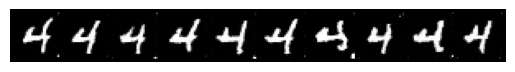

tensor([[-1.0688, -1.7534, -1.1228, -0.0732, -1.2273, -0.3734, -2.2844, -1.3090,
          1.2880, -0.1893],
        [-0.9155, -1.3873, -0.4899,  0.1180, -1.4122, -0.2269, -1.4016, -1.3312,
          1.4772, -0.4181],
        [-0.9868, -1.4458, -0.4845,  0.0928, -1.5260, -0.2288, -1.4181, -1.4346,
          1.5526, -0.5319],
        [-0.7384, -1.1837, -0.3468,  0.2138, -1.2336, -0.1876, -1.1550, -1.1336,
          1.3750, -0.2502],
        [-1.2916, -2.1557, -1.6947, -0.2770, -1.1907, -0.5094, -3.1099, -1.4089,
          1.2028, -0.1126],
        [-0.8559, -1.3648, -0.5654,  0.1240, -1.2696, -0.2410, -1.4812, -1.2177,
          1.3753, -0.2707],
        [-1.2054, -1.8284, -1.2989, -0.2573, -1.0898, -0.5558, -2.5296, -1.2805,
          1.1842, -0.0765],
        [-1.1317, -1.6444, -0.6874, -0.0039, -1.6148, -0.2799, -1.7328, -1.5636,
          1.5894, -0.6061],
        [-0.8339, -1.4211, -0.7842,  0.0795, -1.0752, -0.2971, -1.7597, -1.0936,
          1.2244, -0.0638],
        [-1.0243, -

In [50]:
model.eval()

nsamples = 10

w=7
y=4

# Sample from the model using classifier guidance if weight is non-zero
samples = model.sample((nsamples,28*28), w, y, classifier = classifier).to(device)

# Map pixel values back from [-1,1] to [0,1]
samples = (samples+1)/2 
samples = samples.clamp(0.0, 1.0)

# Plot in grid
grid = utils.make_grid(samples[:10].reshape(-1, 1, 28, 28), nrow=nsamples)
plt.gca().set_axis_off()
plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")



plt.savefig(f'guided_sampling_y{y}_w{w}.png')

plt.show()    
# Test if the classifier would correctly classify the generated samples

# note that the prediction would be the maximum of the output of the classifier
print(classifier(samples, torch.tensor([0]).to(device)))

In [51]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
 
def calculate_inception_score_and_fid(
    generated_samples,
    real_samples,
    batch_size=32,
    device=None,
    resize=True
):
    """
    Calculates Inception Score (IS) and Fréchet Inception Distance (FID) for generated samples.
 
    Args:
        generated_samples (torch.Tensor): Generated images, shape (N, 3, H, W), values in [0, 1].
        real_samples (torch.Tensor): Real images for FID comparison, shape (N, 3, H, W), values in [0, 1].
        batch_size (int): Batch size for processing images.
        device (torch.device): Device to run computations on. If None, uses CUDA if available.
        resize (bool): Whether to resize images to 299x299 required by InceptionV3.
 
    Returns:
        is_mean (float): The Inception Score mean.
        is_std (float): The Inception Score standard deviation.
        fid_score (float): The Fréchet Inception Distance.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
    # Define image transformations
    transform = transforms.Resize((299, 299)) if resize else nn.Identity()
 
    # Initialize metrics
    fid = FrechetInceptionDistance(feature=2048).to(device)
    is_metric = InceptionScore().to(device)
    # Function to preprocess and convert images
    def preprocess(batch):
        # Resize if necessary
        if resize:
            batch = nn.functional.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        # Scale to [0, 255] and convert to uint8
        batch = (batch * 255).clamp(0, 255).to(torch.uint8)
        return batch
 
    # Process generated samples for IS and FID
    for i in range(0, generated_samples.size(0), batch_size):
        batch = generated_samples[i:i + batch_size]
        batch = preprocess(batch).to(device)
        fid.update(batch, real=False)
        is_metric.update(batch)
 
    # Process real samples for FID
    for i in range(0, real_samples.size(0), batch_size):
        batch = real_samples[i:i + batch_size]
        batch = preprocess(batch).to(device)
        fid.update(batch, real=True)
 
    # Compute scores
    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()
 
    return is_mean, is_std, fid_score

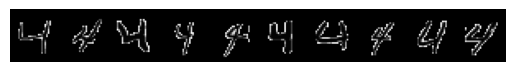

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [52]:
real_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
real_dataset.data = real_dataset.data.to(device).float()
real_dataset.targets = real_dataset.targets.to(device)
real_x = real_dataset.data
real_y = real_dataset.targets

# get samples of fours
real_fours = real_x[real_y == 4]
real_fours = real_fours[:10]

# Plot in grid
grid = utils.make_grid(real_fours.reshape(-1, 1, 28, 28), nrow=nsamples)
plt.gca().set_axis_off()
plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
plt.show()    

samples_fmt, real_fmt = samples.reshape(-1, 1, 28, 28), real_fours.reshape(-1, 1, 28, 28)

#torch cat x3 along dim 1 for each (RGB implementation)
samples_fmt = torch.cat([samples_fmt, samples_fmt, samples_fmt], dim=1).type(dtype=torch.uint8)
real_fmt = torch.cat([real_fmt, real_fmt, real_fmt], dim=1).type(dtype=torch.uint8)

is_mean, is_std, fid_score = calculate_inception_score_and_fid(samples_fmt, real_fmt, batch_size=32, device='cpu')

In [53]:
print(is_mean, is_std, fid_score)

tensor(1.) tensor(5.9605e-08) 357.9425354003906


### Additional stuff I used for testing

I.e. testing out the classifier

In [ ]:
##test for classifier by giving it unnoised MNIST

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset.data = train_dataset.data.to(device)
x_train = train_dataset.data.float()

torch.Size([2, 28, 28])


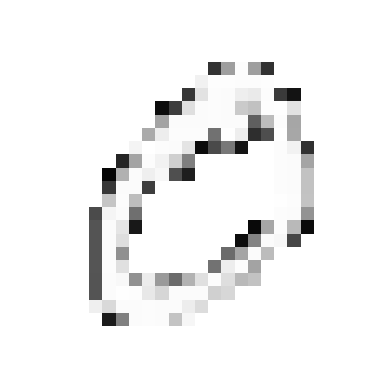

tensor([[ -238.2384,  -660.0082, -1059.8765,    -3.2868, -1222.2327,   338.6720,
          -320.7259,  -704.8042,  -282.9259,  -455.4705],
        [  314.0291,  -861.6416,  -349.7124,  -758.2955,  -293.3600,  -160.5501,
            27.7502,  -384.7800,  -314.4612,  -328.2208]], device='mps:0')
torch.Size([2, 10])
Predicted: tensor([5, 0], device='mps:0')


In [ ]:
test= x_train[:2]#.unsqueeze(0)
print(test.shape)

grid = utils.make_grid(test, nrow=2)
plt.gca().set_axis_off()
plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
plt.show()    

classifier.eval()
with torch.no_grad():
    t = torch.tensor([0]).to(device)
    output = classifier(test, t)
    print(output)
    print(output.shape)
    _, predicted = torch.max(output, 1)
    print(f"Predicted: {predicted}")